In [2]:
from google.colab import drive
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_V2_S_Weights
from torchsummary import summary
import torch.nn as nn
from torch.optim import Adam, SGD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
from PIL import Image
import random
import math

from sklearn.metrics import confusion_matrix

# Mount to Google Drive

In [127]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DRIVE_FOLDER = './drive/MyDrive/Colab Notebooks/2023-trash-classifier-project'
TRAIN_FOLDER = DRIVE_FOLDER + '/train'
VAL_FOLDER = DRIVE_FOLDER + '/val'
TEST_FOLDER = DRIVE_FOLDER + '/test'
MY_DATASET_FOLDER = DRIVE_FOLDER + '/my-collected-dataset'

In [119]:
os.listdir(DRIVE_FOLDER)

['04062023_photos',
 'efficient-v2-s-Adam.pt',
 'val',
 'train',
 'train_utility_functions.py',
 'train.py',
 'test',
 'my-collected-dataset',
 'efficient-v2-s-Adam_best.pt',
 'efficient-v2-s-Adam2_best.pt',
 'efficient-v2-s-Adam2.pt',
 'train.ipynb']

# Set up device


In [6]:
GPU = torch.cuda.is_available()
device = torch.device('cpu')
if (GPU):
  print('Using gpu')
  device = torch.device('cuda')

# Checkpoint

In [7]:
def save_checkpoint(model, history:list, model_name:str, time_elapsed=0):
  """
  This function saves checkpoint of the model.

  Args:
  ====
  model: a Neural Network model that contains `epochs` field. an `optimizer`, and a `scheduler`
  history: a list of tuples (train_loss, val_loss, train_acc, val_acc)
  model name: the name of the model, used as file name when saving the checkpoint

  Return
  ====
  None 
  """
  checkpoint = {}

  checkpoint['classifier'] = model.classifier
  checkpoint['optimizer'] = model.optimizer
  checkpoint['scheduler'] = model.scheduler
  checkpoint['epochs'] = model.epochs
  try:
    model.time_to_train = model.time_to_train + time_elapsed
  except: 
    model.time_to_train = time_elapsed

  checkpoint['time_to_train'] = model.time_to_train 
  checkpoint['state_dict'] = model.state_dict()
  checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()
  if model.scheduler:
    checkpoint['scheduler_state_dict'] = model.scheduler.state_dict()

  checkpoint['history'] = history
  
  path = f'{DRIVE_FOLDER}/{model_name}.pt'
  torch.save(checkpoint, path)


def load_checkpoint(model_name:str, pretrained_model_with_cnnweights):
  '''
  This function loads a checkpoint

  Args
  ====
  model_name: the name of the file

  Returns
  =======
  model: the model attached with its `epochs` field, `optimizer`, and `scheduler`
  history: a list of tuples (train_loss, val_lost, train_acc, val_acc)
  '''
  path = f'{DRIVE_FOLDER}/{model_name}.pt'
  checkpoint = torch.load(path, map_location=device)

  model = pretrained_model_with_cnnweights
  for param in model.parameters():
    param.requires_grad = False

  classifier = checkpoint['classifier']
  model.classifier = classifier
  model.load_state_dict(checkpoint['state_dict'])

  model.optimizer = checkpoint['optimizer']
  model.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  model.scheduler = checkpoint['scheduler']
  if model.scheduler:
    model.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

  model.epochs = checkpoint['epochs']
  model.time_to_train = checkpoint['time_to_train']

  history = checkpoint['history']

  return model, history

# Data


## Transformations

In [8]:
IMAGENET_MEANS = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

In [9]:
def transforms1():
  """
  This function returns a torchvision.transforms
  """
  my_transforms = {
      'train': transforms.Compose([
          transforms.RandAugment(), 
          transforms.ToTensor(),
          transforms.Normalize(IMAGENET_MEANS, IMAGENET_STD)
      ]),
      'val': transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(IMAGENET_MEANS, IMAGENET_STD)
      ]),
      'test': transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(IMAGENET_MEANS, IMAGENET_STD)
      ])
  }

  return my_transforms

In [130]:
def resize_to_224(PIL_img):
    """
    This function receives a PIL image and resize it into (224,224)

    Returns:
    =======
    PIL Image
    """
    # padding if width or height is smaller than 224
    width = PIL_img.size[0]
    height = PIL_img.size[1]
    left_pad = 0
    right_pad = 0
    top_pad = 0
    bottom_pad = 0
    if (width<224):
        left_pad = int((224-width)/2)
        right_pad = 224 - width-left_pad
    
    if (height<224):
        top_pad = int((224-height)/2)
        bottom_pad = 224-height-top_pad

    pad_transform = transforms.Pad((left_pad, top_pad, right_pad, bottom_pad))
    transformed_image = pad_transform(PIL_img)

    # scaling big image to small image
    transformed_image = transformed_image.resize((224,224))
    return transformed_image


## DataLoaders

In [10]:
def get_trash_dataloaders(transforms: dict, batch_size=128):
  """
  This functions return a train DataLoader, a test DataLoader, and a validation DataLoader
  Batch Size = 128
  Args:
  ====
  transforms (dict): a dictionary defining the transformations to apply on train dataset, test dataset, and val_dataset 

  Returns:
  =======
  train_loader: DataLoader
  val_loader: DataLoader
  test_loader: TestLoader
  """
  train_dataset = datasets.ImageFolder(TRAIN_FOLDER, transforms['train'])
  test_dataset = datasets.ImageFolder(TEST_FOLDER, transforms['val'])
  val_dataset = datasets.ImageFolder(VAL_FOLDER, transforms['test'])

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  return train_loader, val_loader, test_loader

In [11]:
train_loader, val_loader, test_loader = get_trash_dataloaders(transforms1())

In [12]:
CLASS_TO_IDX = test_loader.dataset.class_to_idx
IDX_TO_CLASS = {CLASS_TO_IDX[k]:k for k in CLASS_TO_IDX.keys()}
print(CLASS_TO_IDX)
print(IDX_TO_CLASS)

{'bio': 0, 'glass': 1, 'metals_and_plastic': 2, 'non_recyclable': 3, 'other': 4, 'paper': 5, 'unknown': 6}
{0: 'bio', 1: 'glass', 2: 'metals_and_plastic', 3: 'non_recyclable', 4: 'other', 5: 'paper', 6: 'unknown'}


In [13]:
# iterator = iter(train_loader)
# data, target = next(iterator)
# print(data.shape)
# print(data)
# print(target)
# print(target.shape)

In [14]:
  # test_dataset = datasets.ImageFolder(TEST_FOLDER, transforms1()['test'])
  # test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)


# Train Function

In [15]:
def train(model, criterion, train_loader, val_loader, epochs, model_name, history=[], max_epochs_stop=3, print_every=2, save_every=4):
  """
  This function trains a neural network. Using early stopping as overfitting occurs.

  Args:
  =====
  model: a model to train. It must be attached with a `scheduler` and an `optimizer`. Calling `model(x)` produces yhat
  criterion: a loss function
  train_loader: a DataLoader for training
  val_loader: a DataLoader for validation
  epochs: total training epochs
  model_name: used as filename when saving checkpoint
  save_every: save model after `save_every` number of epochs
  print_every: print the train/val loss  and train/val accuracy after every `print_every` number of epochs

  Return:
  ======
  None
  """
  model = model.to(device)
  start = timer()

  smallest_val_loss = np.inf
  no_improved_epochs = 0
  best_val_acc = 0 

  try:
    print(f"Model has been trained for {model.epochs} epochs.")
    start_epochs = model.epochs+1
  except:
    print("Start training from scratch.")
    start_epochs = 0
    model.epochs = 0

  for e in range(start_epochs, epochs):
    model.train()

    train_running_loss = 0
    train_running_corrects = 0
    val_running_loss = 0
    val_running_corrects = 0
    train_size = 0
    val_size = 0

    for i, (data, target) in enumerate(train_loader):
      data = data.to(device)
      target = target.to(device)

      # train
      model.optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      model.optimizer.step()

      # accumulate train loss and train acc
      _, preds = output.max(1)
      correct_preds = (preds==target).sum()
      train_running_corrects += correct_preds
      train_running_loss += loss.item()*data.size(0)
      train_size += data.size(0)
      #print(f'Epoch %d: %.2f%% completes.'%(e, (i+1)*100.0/len(train_loader)))

    else:
      model.epochs += 1

      model.eval()
      with torch.no_grad():
        for data, target in val_loader:
          data = data.to(device)
          target = target.to(device)

          # eval
          output = model(data)
          loss = criterion(output, target)

          _, preds = output.max(1)
          correct_preds = (preds==target).sum()
          val_running_corrects += correct_preds
          val_running_loss += loss.item()*data.size(0)
          val_size +=data.size(0)
        
      
    # save history for one epoch
    train_acc = train_running_corrects/train_size
    train_loss = train_running_loss/train_size
    val_acc = val_running_corrects/val_size
    val_loss = val_running_loss/val_size
    history.append((train_acc, train_loss, val_acc, val_loss))

    if (e%print_every==0):
      print(f"FINISH EPOCH {e}, training loss={train_loss:.2f}, validation loss={val_loss:.2f}")
      print(f"\t Training accuracy={train_acc*100.0:.2f}%, validation accuracy={val_acc*100.0:.2f}%")


    # save model every n epochs
    if ((e+1)%save_every==0 or e==e-1):
      print(f"Saving {model_name}.pt ...")

      time_elapsed = timer()-start
      save_checkpoint(model, history, model_name, time_elapsed)
      start = timer()

    # save the best model
    if (val_loss<smallest_val_loss):
      print(f"Saving {model_name}_best.pt ...")
      save_checkpoint(model, history, model_name+'_best')

      no_improved_epochs = 0
      smallest_val_loss = val_loss
      best_val_acc = val_acc

    else:
      no_improved_epochs += 1
    
    # early stopping
    if (no_improved_epochs==max_epochs_stop):
        print(f"FINISH TRAINING, lowest val loss is {smallest_val_loss:.2f}")
        print(f"\t Best accuracy is {best_val_acc:.2f}")
        return


  print(f"FINISH TRAINING, lowest val loss is {smallest_val_loss:.2f}")
  print(f"\t Best accuracy is {best_val_acc:.2f}") 



# Test function

In [16]:
def test(model, test_loader: DataLoader):
  '''
  This function computes a model's accuracy on a test DataLoader

  Args:
  ====
  model: a model to test. Calling model(x) returns yhat
  test_loader: a DataLoader for testing set

  Returns:
  =======
  Accuracy Rate: float between 0 and 1
  '''
  model.to(device)

  model.eval() # for dropout models, no dropout applied during evaluation/test
  running_corrects = 0
  size = 0

  with torch.no_grad():
    for x,y in test_loader:
      x = x.to(device)
      y = y.to(device)

      output = model(x)
      _, preds = output.max(1)
      running_corrects += (preds==y).sum()
      size += x.size(0)

  return running_corrects*1.0/size


# Plots function

In [17]:
def plot_train_val_loss(history: pd.DataFrame, model_name, ylim: tuple, xlim: tuple):
  '''
  This function plots the train loss and validation loss

  Args:
  =====
  history (DataFrame): has two columns: `train loss` and `val loss`
  model_name: is the name of the model
  ylim (tuple): y range to zoom in
  '''
  plt.plot(range(1, len(history)+1), history['train loss'], label='train loss')
  plt.plot(range(1, len(history)+1), history['val loss'], label='validation loss')
  plt.legend()

  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.title(f'Training Loss and Validation Loss of {model_name}')

  if (ylim):
    plt.ylim(ylim)

  if (xlim):
    plt.xlim(xlim)

  plt.savefig(f'loss_{model_name}.png')

  plt.show()

def plot_train_val_acc(history: pd.DataFrame, model_name, ylim: tuple, xlim: tuple):
  '''
  This functions plots the train accuracy and validation accuracy

  Args:
  =====
  history (DataFrame): has two columns: `train acc` and `val acc`
  model_name: is the name of the model
  ylim (tuple): y range to zoom in
  '''

  plt.plot(range(1, len(history)+1), history['train acc'], label='train accuracy')
  plt.plot(range(1, len(history)+1), history['val acc'], label='validation accuracy')
  plt.legend()


  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  plt.title(f'Training Accuracy and Validation Accuracy of {model_name}')

  if (ylim):
    plt.ylim(ylim)

  if (xlim):
    plt.xlim(xlim)

  plt.savefig(f'acc_{model_name}.png')

  plt.show()


# Model

In [18]:
def pretrained_efficientnet_v2_s1(summarize=False):
  """
  This function returns a pretrained efficientnet_v2_s with a custom classifier
  """
  # load model
  efficientnet_v2_s = models.efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)

  # freeze parameters
  for param in efficientnet_v2_s.parameters():
    param.requires_grad = False
  
  # add custom classifier
  custom_classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=7),
    nn.Softmax(1)
  )
  efficientnet_v2_s.classifier = custom_classifier

  # to device
  efficientnet_v2_s = efficientnet_v2_s.to(device)

  if summarize:
    if GPU:
      summary(efficientnet_v2_s, (3,224,224), 128, "cuda")
    else:
      summary(efficientnet_v2_s, (3,224,224), 128, "cpu")

  return efficientnet_v2_s

# Training

In [19]:
train_loader, val_loader, test_loader = get_trash_dataloaders(transforms1())

In [20]:
model, history = load_checkpoint("efficient-v2-s-Adam2_best", pretrained_efficientnet_v2_s1())

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 49.2MB/s]


In [ ]:
# history

In [22]:
# model = pretrained_efficientnet_v2_s1()
# optimizer = Adam(model.parameters())
# model.optimizer = optimizer
# model.scheduler = None

In [23]:
criterion = nn.CrossEntropyLoss()
model = model.to(device)
# train(model, criterion, train_loader, val_loader, 100, "efficient-v2-s-Adam2", history)

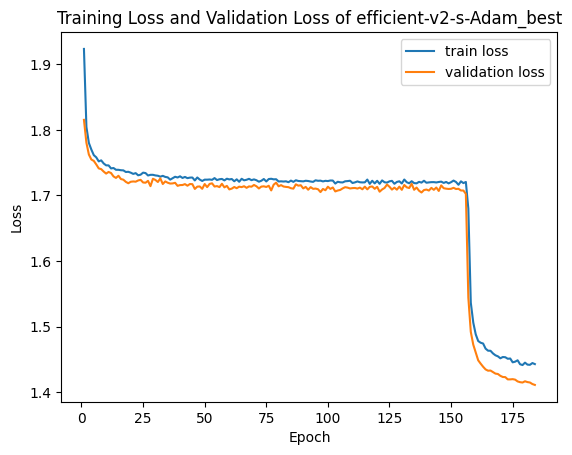

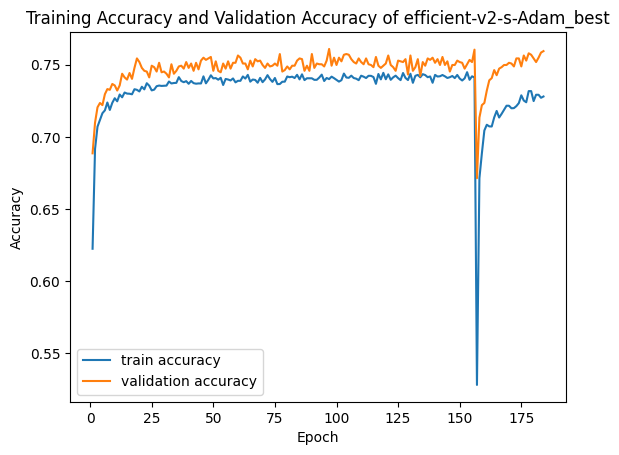

Fully Connect Neural Network with Dropout, test  accuracy:  0.7766287326812744


In [24]:
model, history = load_checkpoint('efficient-v2-s-Adam2_best', pretrained_efficientnet_v2_s1())

history = pd.DataFrame(history, columns=['train acc', 'train loss', 'val acc', 'val loss'])
plot_train_val_loss(history, 'efficient-v2-s-Adam_best', None, None)
plot_train_val_acc(history, 'efficient-v2-s-Adam_best', None, None)

acc = test(model, test_loader)
print('Fully Connect Neural Network with Dropout, test  accuracy: ', acc.item())

# Make Predictions

In [44]:
def pred(file_location: str, model, truth):
  """
  This function makes prediction on a image file

  Args:
  ====
  file_location (str): image path
  model (Pytorch model)
  truth: the truth label
  """
  pred_transform = transforms1()['test']

  # open image 
  image = Image.open(file_location)
  print('Image: ')
  image.show()

  # and apply transformation
  tf_img = pred_transform(image)
  # print(tf_img)
  tf_img = tf_img.to(device)
  tf_img = tf_img[None, :, :, :]

  # make prediction and print
  model.eval()
  with torch.no_grad():
    props = model(tf_img)
  _, idx = props.max(1)
  print(props)
  idx = idx[0].item()

  print('Actual Label: ', truth)
  print('Model prediction: ', IDX_TO_CLASS[idx])

In [26]:
model, history = load_checkpoint('efficient-v2-s-Adam_best', pretrained_efficientnet_v2_s1())

Image: 


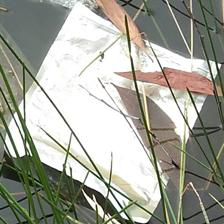

tensor([[7.2143e-06, 1.2284e-02, 6.1579e-01, 9.6653e-03, 2.0365e-03, 7.4840e-03,
         3.5274e-01]])
Actual Label:  paper
Model prediction:  metals_and_plastic


In [53]:
# pick random one category
categories = os.listdir(TEST_FOLDER)
c = random.choice(categories)

# pick random image in the category
images = os.listdir(TEST_FOLDER+'/'+c)
i = random.choice(images)

# form path
path ='/'.join([TEST_FOLDER, c, i])

# Load model and pred
pred(path, model, c)

# Function to evaluate over all classes

In [75]:
def plot_confusion_matrix(cf_matrix):
  """
  Receive a confusion maxtrix to rows are the predicted labels and columns are the true labels
  """
  df_cf_matrix = pd.DataFrame(cf_matrix, index=CLASS_TO_IDX.keys(), columns=CLASS_TO_IDX.keys())  
  df_cf_matrix_percent = pd.DataFrame(cf_matrix/np.sum(cf_matrix, axis=0), index=CLASS_TO_IDX.keys(), columns=CLASS_TO_IDX.keys())  

  plt.figure(figsize=(10, 7))
  ax1 = plt.subplot(2, 1, 1)
  ax2 = plt.subplot(2, 1, 2)
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=1)
  
  sns.heatmap(df_cf_matrix, annot=True, ax=ax1, cmap="Blues")
  ax1.set_xlabel('True Label', fontsize=14)
  ax1.set_ylabel('Predicted Label', fontsize=14)
  sns.heatmap(df_cf_matrix_percent, annot=True, ax=ax2, cmap="Blues")
  ax2.set_xlabel('True Label', fontsize=14)
  ax2.set_ylabel('Predicted Label', fontsize=14)

In [99]:
def compute_precision_recall(cf_matrix):
  """
  Receive a confusion maxtrix to rows are the predicted labels and columns are the true labels
  precision = TP/(TP+FP)

  recall = TP/(TP+FN)
  """
  # precision
  mt = cf_matrix/np.sum(cf_matrix, axis=1)
  precisions = []
  for i, a in enumerate(mt):
    precisions.append(round(a[i], 2))

  # recall
  mt = cf_matrix/np.sum(cf_matrix, axis=0)
  recalls = []
  for i, a in enumerate(mt):
    recalls.append(round(a[i], 2))

  # f1 score
  f1 = []
  for i, precision in enumerate(precisions):
    f1.append(round(2*precision*recalls[i]/(precision+recalls[i]), 2))

  df = pd.DataFrame(data=np.array([precisions, recalls, f1]).T, index=['bio', 'glass', 'metals and plastic', 'non recyclable', 'other', 'paper', 'unknown litter'], columns=['Precision', 'Recall', 'F1-Score'])
  return precisions, recalls, f1, df

In [32]:
def model_confusion_matrix(test_loader, model):
  model.eval()

  y_true = []
  y_pred = []
  for x, labels in test_loader:
    x = x.to(device)
    labels = labels.to(device)

    outputs = model(x)
    _, preds = outputs.max(1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())
  
  cf_matrix = confusion_matrix(y_true, y_pred)
  
  return cf_matrix

In [31]:
model, history = load_checkpoint('efficient-v2-s-Adam2_best', pretrained_efficientnet_v2_s1())

In [33]:
confusion_matrix = model_confusion_matrix(test_loader, model)

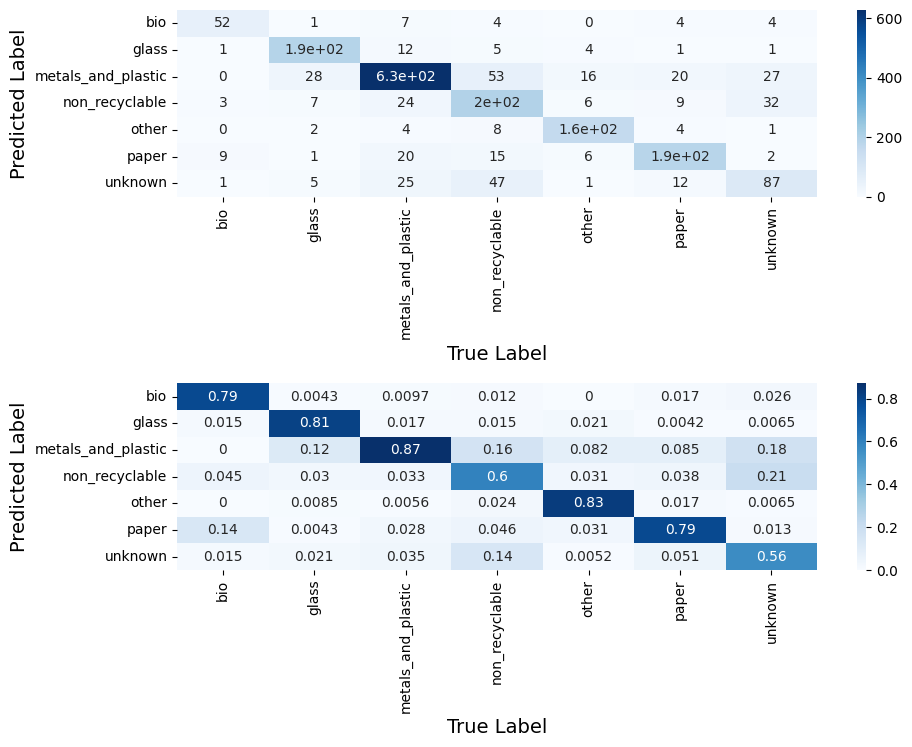

In [100]:
plot_confusion_matrix(confusion_matrix.T)

In [101]:
compute_precision_recall(confusion_matrix)

([0.79, 0.81, 0.87, 0.6, 0.83, 0.79, 0.56],
 [0.72, 0.89, 0.81, 0.71, 0.89, 0.78, 0.49],
 [0.75, 0.85, 0.84, 0.65, 0.86, 0.78, 0.52],
                     Precision  Recall  F1-Score
 bio                      0.79    0.72      0.75
 glass                    0.81    0.89      0.85
 metals and plastic       0.87    0.81      0.84
 non recyclable           0.60    0.71      0.65
 other                    0.83    0.89      0.86
 paper                    0.79    0.78      0.78
 unknown litter           0.56    0.49      0.52)

# Test using my own dataset

In [131]:
def pred2(file_location: str, model):
  """
  This function makes prediction on a image file

  Args:
  ====
  file_location (str): image path
  model (Pytorch model)

  Returns
  =======

  """
  pred_transform = transforms1()['test']

  # open image 
  image = Image.open(file_location)

  # and apply transformation
  tf_img = resize_to_224(image)
  tf_img = pred_transform(tf_img)
  tf_img = tf_img.to(device)
  tf_img = tf_img[None, :, :, :]

  # make prediction and print
  model.eval()
  with torch.no_grad():
    props = model(tf_img)
  prop, idx = props.max(1)
  idx = idx[0].item()
  
  return IDX_TO_CLASS[idx], prop

In [113]:
model, history = load_checkpoint('efficient-v2-s-Adam2_best', pretrained_efficientnet_v2_s1())

Accuracy:  0.5


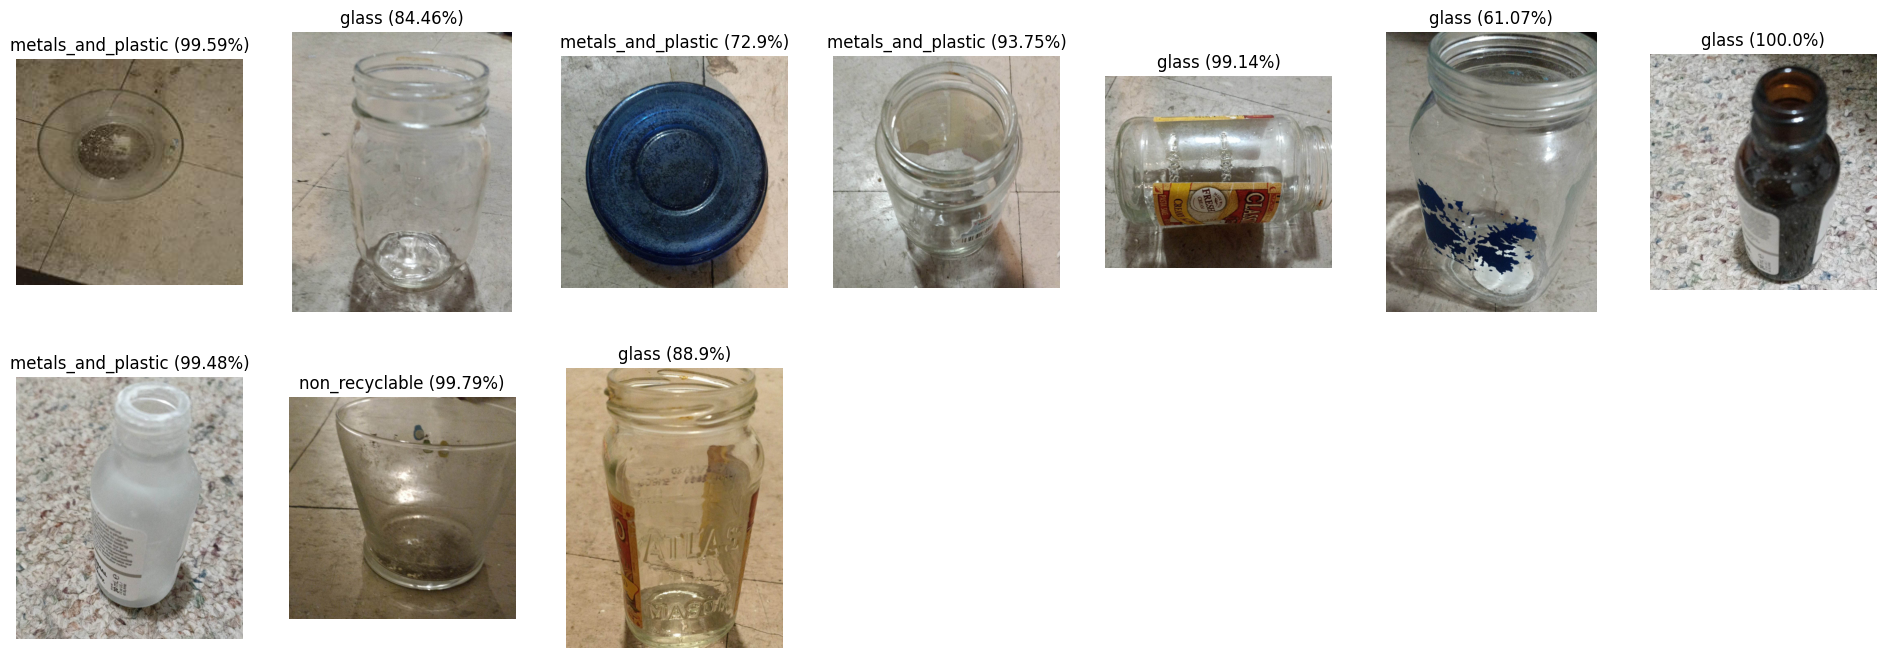

In [139]:
plt.figure(figsize=(24,8))

categories = ['bio', 'glass', 'non_recyclable', 'other', 'paper', 'metals_and_plastic']
category = 'glass'

# all images in the category folder
all_images = os.listdir(MY_DATASET_FOLDER+'/'+category)
images_count = len(all_images)
cols = 7
rows = math.ceil(images_count/5)
correct_preds = 0

for i in range(images_count):
  # construct path to image
  image_path = '/'.join([MY_DATASET_FOLDER, category, all_images[i]])

  # show image
  ax = plt.subplot(rows, cols, i+1)
  ax.imshow(Image.open(image_path))
  ax.axis('off')

  # Load model and pred
  label, prop = pred2('/'.join([MY_DATASET_FOLDER, category, all_images[i]]), model)
  ax.set_title(label + ' (' + str(round(prop.item()*10000)/100.0) + '%)')
  if label==category:
    correct_preds += 1

plt.savefig('paper')
print('Accuracy: ', correct_preds*1.0/images_count)
